In [3]:
import os
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import numpy as np
from configs import get_datasets
from critic import LinearCritic
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from PIL import Image
from models import *
import torch.backends.cudnn as cudnn
from tqdm import tqdm
import math
import seaborn as sns


### config ####
num_workers = 2
batch_size = 512
img_size = 32
temperature = 0.5
dataset = 'cifar10'
CACHED_MEAN_STD = {
        'cifar10': ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        'cifar100': ((0.5071, 0.4865, 0.4409), (0.2009, 0.1984, 0.2023)),
        'stl10': ((0.4409, 0.4279, 0.3868), (0.2309, 0.2262, 0.2237)),
        'imagenet': ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    }

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
##### Transformation #####
def ColourDistortion(s=1.0):
    # s is the strength of color distortion.
    color_jitter = transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    rnd_color_jitter = transforms.RandomApply([color_jitter], p=0.8)
    rnd_gray = transforms.RandomGrayscale(p=0.2)
    color_distort = transforms.Compose([rnd_color_jitter, rnd_gray])
    return color_distort


transform_train = transforms.Compose([
        transforms.RandomResizedCrop(img_size, interpolation=Image.BICUBIC),
        transforms.RandomHorizontalFlip(),
        ColourDistortion(s=0.5),
        transforms.ToTensor(),
        transforms.Normalize(*CACHED_MEAN_STD[dataset]),
    ])


# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Files already downloaded and verified
Files already downloaded and verified


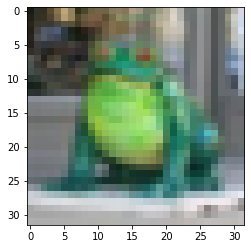

In [5]:
root = '/data/cifar10/'
train = torchvision.datasets.CIFAR10(root = root, train=True, download=True)
test = torchvision.datasets.CIFAR10(root = root, train = False, download = True)
pic = train[19][0]
plt.imshow(pic)

In [6]:
##### generate data ######

root = '/data/cifar10/'
train = torchvision.datasets.CIFAR10(root = root, train=True, download=True)
test = torchvision.datasets.CIFAR10(root = root, train = False, download = True)
    
def x_to_xaug(data, sample = 100, index = 0):
    '''
    Input : a list of picture, index of the pic we want, number of sample generate
    
    Output: list of pictures each have 2 random augmentations on it
    '''
    x = []
    original_pic = data[index][0]
    for i in range(sample):
        transform_pic = transform_train(original_pic)
        x.append(transform_pic)
    return x

def gen_data(B = 500, sample = 100):
    '''
    B = image batch
    num_aug = number of augmented picture for each image 
    
    return x_train, x_test (list) [[pic1_aug1, pic1_aug2, .....], [pic2_aug1, pic2_aug2, ...], ...]
    '''
    idx_train = np.random.randint(low = 0, high = len(train), size = B)
    idx__test = np.random.randint(low = 0, high = len(test), size = B)
    #sample augmented image !
    X_train = [x_to_xaug(data = train, sample = sample, index = idx_train[i]) for i in range(B)]
    X_test = [x_to_xaug(data = test, sample = sample, index = idx__test[i]) for i in range(B)]
    
    return X_train, X_test


# get data for x with only one sample for each image 
def gen_data_1pic(B = 100):
    '''
    the main difference between this function and gen_data is that this function return
    a list [augpic1, augpic2, ...., augpic n] each original picture is selected once
    '''
    train, test = gen_data(B=B, sample = 1)
    X_train1 = [train[i][0] for i in range(len(train))]
    X_test1 = [test[i][0] for i in range(len(test))]
    return [X_train1], [X_test1]


Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


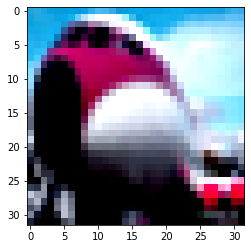

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


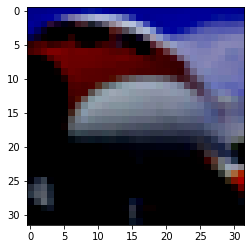

In [7]:
randomseed = 1
np.random.seed(randomseed) # random seed for pictures but not augmentation
X_train, X_test = gen_data(B=20, sample = 100)
#illustration
for i in range(2):
    imshow(X_train[0][i])

In [8]:
##### load checkpoint ! ######
def get_net(filename):
    '''
    Input: checkpoint filename
    Return: net, critic
     
    '''
    
    net = ResNet18()
    net = net.to(device)

    if device == 'cuda':
        repr_dim = net.representation_dim
        net = torch.nn.DataParallel(net)
        net.representation_dim = repr_dim
        cudnn.benchmark = True

    #print('==> Loading encoder from checkpoint..')
    resume_from = os.path.join('./checkpoint', filename)
    checkpoint = torch.load(resume_from)
    net.load_state_dict(checkpoint['net'])
    
    #load critics
    critics = LinearCritic(net.representation_dim, temperature=temperature).to(device)
    critics.load_state_dict(checkpoint['critic'])
    
    return net, critics

In [9]:
def x_to_h(x, net):
    '''
    Input x (list) , net, critics
    
    return h(list), for that list x
    '''
    h = []
    net.eval()
    with torch.no_grad():
        for i in range(len(x)):
            x_i = x[i].unsqueeze(0)
            h_i = net(x_i)
            h.append(h_i)
    return h

In [10]:
def h_to_z(h, critics):
    z = []
    critics.eval()
    with torch.no_grad():
        for i in range(len(h)):
            z_i = critics.project(h[i])
            z.append(z_i)
    return z

In [11]:
def h_to_cov(h):
    h_np = np.array([h[i].cpu().detach().numpy()[0] for i in range(len(h))])
    covMatrix = np.cov(h_np)
    
    return covMatrix

In [12]:
def cal_trace(covMatrix):
    return np.trace(covMatrix)

def cal_det(covMatrix):
    return(np.linalg.det(covMatrix))

In [13]:

def my_plot2(train_dict, test_dict, title = 'trace of covariance h|x' , label1 = 'train', label2 = 'test'):
    plt.plot([99+ 100*i for i in range(10)], [train_dict[cp] for cp in checkpointfile], label = label1, color = 'r')
    plt.plot([99+ 100*i for i in range(10)], [test_dict[cp] for cp in checkpointfile], label = label2, color = 'b')
    plt.xlabel('epochs')
    plt.title(title)
    plt.legend()
    plt.show()
        
    
def my_plot1(train_dict, title = 'trace of covariance h|x', label1 = 'train'):
    plt.plot([99+ 100*i for i in range(10)], [train_dict[cp] for cp in checkpointfile], label = label1, color = 'b')
    plt.xlabel('epochs')
    plt.title(title)
    plt.legend()
    plt.show()
    
def my_plot(list, title = 'best accuracy each checkpoint', label1 = 'best_acc'):
    plt.plot([99+ 100*i for i in range(10)], [list[i] for i in range(10)], label = label1, color = 'b')
    plt.xlabel('epochs')
    plt.title(title)
    plt.legend()
    plt.show()

# Look at covariance matrix of h|x, z|x

In [14]:
def x_to_cov(X, filename):
    net, critics = get_net(filename)
    
    cov_H = []
    cov_Z = []
    for i in range(len(X)):
        x_i = X[i]  # list of augmented images that come from the same original pic
        h_i = x_to_h(x_i, net)
        z_i = h_to_z(h_i, critics)
        cov_h_i = h_to_cov(h_i) # calculate covariance matrix
        cov_z_i = h_to_cov(z_i)
        
        cov_H.append(cov_h_i)
        cov_Z.append(cov_z_i)
        
    return cov_H, cov_Z

def x_to_logdet(X, filename):
    net, critics = get_net(filename)
    
    logdet_H = []
    logdet_Z = []
    for i in range(len(X)):
        x_i = X[i]  # list of augmented images that come from the same original pic
        h_i = x_to_h(x_i, net)
        z_i = h_to_z(h_i, critics)
        cov_h_i = h_to_cov(h_i) # calculate covariance matrix
        cov_z_i = h_to_cov(z_i)
        
        det_h_i = np.linalg.det(cov_h_i + np.identity(cov_h_i.shape[0])*0.01)
        det_z_i = np.linalg.det(cov_z_i + np.identity(cov_z_i.shape[0])*0.01)
        if(det_h_i !=0):     
            log_det_h_i = np.log(det_h_i)
            logdet_H.append(log_det_h_i)
            
        if(det_z_i !=0):         
            log_det_z_i = np.log(det_z_i)
            logdet_Z.append(log_det_z_i)
        
    return logdet_H, logdet_Z



def x_to_trace(X, filename):
    net, critics = get_net(filename)
    
    trace_H = []
    trace_Z = []
    for i in range(len(X)):
        x_i = X[i]  # list of augmented images that come from the same original pic
        h_i = x_to_h(x_i, net)
        z_i = h_to_z(h_i, critics)
        cov_h_i = h_to_cov(h_i) # calculate covariance matrix
        cov_z_i = h_to_cov(z_i)
        
        trace_h_i = cal_trace(cov_h_i) # calculate trace
        trace_z_i = cal_trace(cov_z_i) # calculate trace
        
        trace_H.append(trace_h_i)
        trace_Z.append(trace_z_i)
        
    return trace_H, trace_Z
       
def Batch_x_to_value(X, checkpointfile, mode = 'trace'):
    if (mode == 'trace'):
        avg_trace_h = {}
        avg_trace_z = {}
        for filename in tqdm(checkpointfile):
            trace_H_i, trace_Z_i = x_to_trace(X, filename)
            avg_trace_H_i = np.mean(trace_H_i)
            avg_trace_Z_i = np.mean(trace_Z_i)

            avg_trace_h[filename] = avg_trace_H_i
            avg_trace_z[filename] = avg_trace_Z_i

        return avg_trace_h, avg_trace_z
    elif (mode == 'log_det'):
        avg_logdet_h = {}
        avg_logdet_z = {}
        for filename in tqdm(checkpointfile):
            logdet_H_i, logdet_Z_i = x_to_logdet(X, filename)
            avg_logdet_H_i = np.mean(logdet_H_i)
            avg_logdet_Z_i = np.mean(logdet_Z_i)

            avg_logdet_h[filename] = avg_logdet_H_i
            avg_logdet_z[filename] = avg_logdet_Z_i

        return avg_logdet_h, avg_logdet_z
            
        
        
    

In [79]:
#Gendata
X_train, X_test = gen_data(B=100, sample = 100)
checkpointfile = ['resnet18_new.pth99']+ ['resnet18_new.pth' + str(i) + '99' for i in range(1,10)]

In [80]:
#Get trace
tr_cov_h_giv_x_train, tr_cov_z_giv_x_train = Batch_x_to_value(X_train, checkpointfile)

100%|██████████| 10/10 [07:12<00:00, 43.21s/it]


In [81]:
tr_cov_h_giv_x_test, tr_cov_z_giv_x_test = Batch_x_to_value(X_test, checkpointfile)

100%|██████████| 10/10 [07:09<00:00, 43.00s/it]


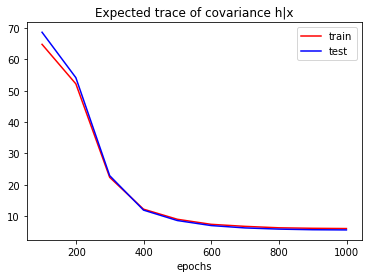

In [131]:
my_plot2(tr_cov_h_giv_x_train, tr_cov_h_giv_x_test, title = 'Expected trace of covariance h|x')

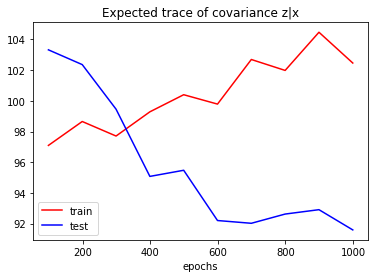

In [132]:
my_plot2(tr_cov_z_giv_x_train, tr_cov_z_giv_x_test, title = 'Expected trace of covariance z|x')

# Log det

In [84]:
logdet_cov_h_giv_x_train, logdet_cov_z_giv_x_train = Batch_x_to_value(X_train, checkpointfile, mode = 'log_det')

100%|██████████| 10/10 [08:16<00:00, 49.61s/it]


In [85]:
logdet_cov_h_giv_x_test, logdet_cov_z_giv_x_test = Batch_x_to_value(X_test, checkpointfile, mode = 'log_det')

100%|██████████| 10/10 [08:19<00:00, 49.94s/it]


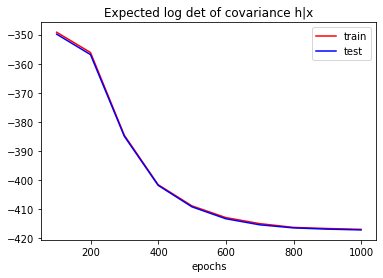

In [133]:
my_plot2(logdet_cov_h_giv_x_train, logdet_cov_h_giv_x_test, title = 'Expected log det of covariance h|x')

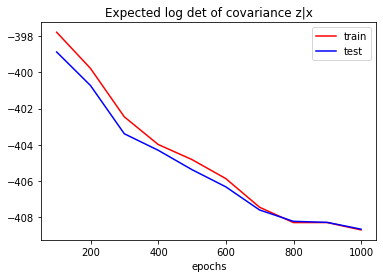

In [134]:
my_plot2(logdet_cov_z_giv_x_train, logdet_cov_z_giv_x_test, title = 'Expected log det of covariance z|x')

# Look at tr cov h/ log det cov h

In [92]:
X_train1 , X_test1 = gen_data_1pic(B = 100)

In [124]:
#Get trace
tr_cov_h_train, tr_cov_z_train = Batch_x_to_value(X_train1, checkpointfile, mode = 'trace')

100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


In [94]:
tr_cov_h_test, tr_cov_z_test = Batch_x_to_value(X_test1, checkpointfile, mode = 'trace')

100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


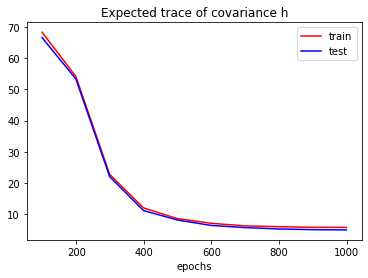

In [136]:
my_plot2(tr_cov_h_train, tr_cov_h_test, title = 'Expected trace of covariance h')

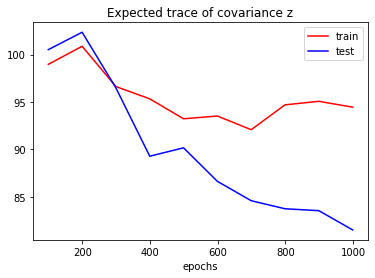

In [137]:
my_plot2(tr_cov_z_train, tr_cov_z_test, title = 'Expected trace of covariance z')

In [97]:
#Get trace
logdet_cov_h_train, logdet_cov_z_train = Batch_x_to_value(X_train1, checkpointfile, mode = 'log_det')

100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


In [98]:
#Get trace
logdet_cov_h_test, logdet_cov_z_test = Batch_x_to_value(X_test1, checkpointfile, mode = 'log_det')

100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


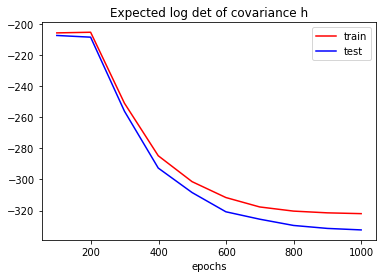

In [138]:
my_plot2(logdet_cov_h_train, logdet_cov_h_test, title = 'Expected log det of covariance h')

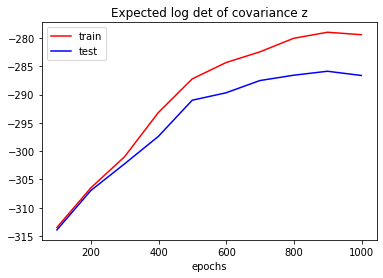

In [139]:
my_plot2(logdet_cov_z_train, logdet_cov_z_test, title = 'Expected log det of covariance z')

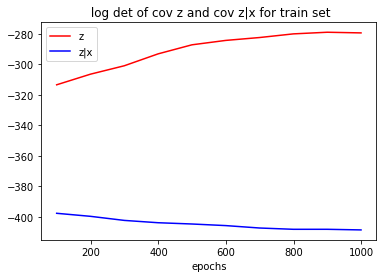

In [140]:
my_plot2(logdet_cov_z_train, logdet_cov_z_giv_x_train, label1 = 'z', label2 = 'z|x', title= ' log det of cov z and cov z|x for train set')

# Look at mutual information I(X;Z)

I(X;Z) = H(Z) - H(Z|X)

In [102]:
def plot_diff(dict1,dict2, title = 'H(Z) - H(Z|X)', label1 = 'train'):
    A = list(dict1.values())
    B = list(dict2.values())
    A_B = [A[i]-B[i] for i in range(len(A))]
    my_plot(A_B, title = title, label1 = 'train')

In [103]:
def plot_same_start(dict1,dict2, title = 'H(Z) - H(Z|X)', label1 = 'log det cov z', label2 = 'log det cov z|x'):
    A = list(dict1.values())
    B = list(dict2.values())
    A_tf = [A[i] - A[0] for i in range(len(A))]
    B_tf = [B[i] - B[0] for i in range(len(B))]
    plt.plot([99+ 100*i for i in range(10)], [A_tf[i] for i in range(10)], label = label1, color = 'r')
    plt.plot([99+ 100*i for i in range(10)], [B_tf[i] for i in range(10)], label = label2, color = 'b')
    plt.xlabel('epochs')
    plt.title(title)
    plt.legend()
    plt.show()

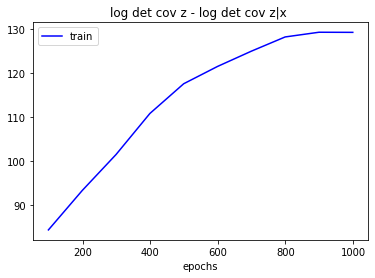

In [142]:
plot_diff(logdet_cov_z_train, logdet_cov_z_giv_x_train, title = 'log det cov z - log det cov z|x ')

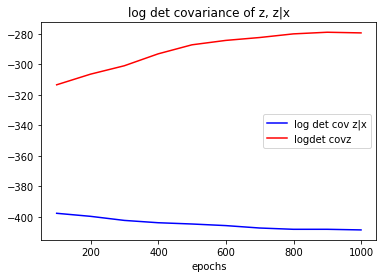

In [114]:
my_plot2(logdet_cov_z_giv_x_train,logdet_cov_z_train, label2 = 'logdet covz', label1 = 'log det cov z|x', title = 'log det covariance of z, z|x')

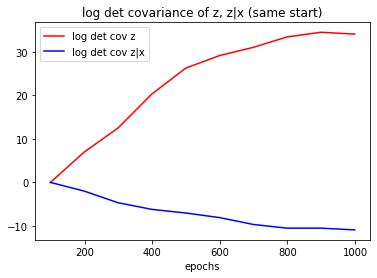

In [141]:
plot_same_start(logdet_cov_z_train, logdet_cov_z_giv_x_train, title = 'log det covariance of z, z|x (same start)', label1 = 'log det cov z', label2 = 'log det cov z|x')

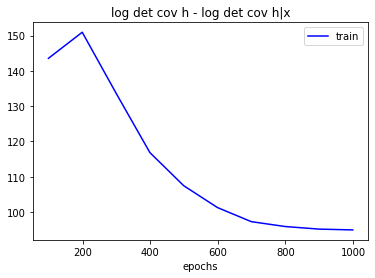

In [143]:
plot_diff(logdet_cov_h_train, logdet_cov_h_giv_x_train, title = 'log det cov h - log det cov h|x')

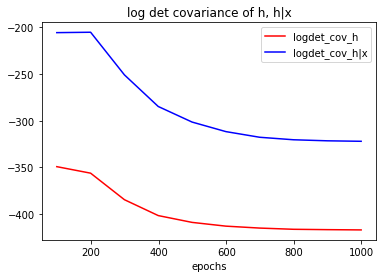

In [144]:
my_plot2(logdet_cov_h_giv_x_train,logdet_cov_h_train, label2 = 'logdet_cov_h|x', label1 = 'logdet_cov_h', title = 'log det covariance of h, h|x')

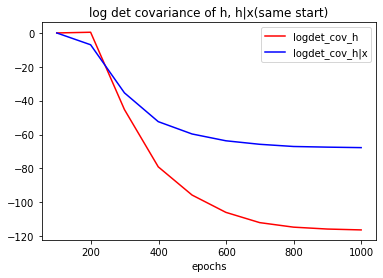

In [145]:
plot_same_start(logdet_cov_h_train, logdet_cov_h_giv_x_train, title = 'log det covariance of h, h|x(same start)',
               label1 = 'logdet_cov_h', label2 = 'logdet_cov_h|x')

### unfortunately the (approximated) mutual information does not go down??

In [41]:
X_train1 , X_test1 = gen_data_1pic(B = 20)
logdet_cov_h_train_20, logdet_cov_z_train_20 = Batch_x_to_value(X_train1, checkpointfile, mode = 'log_det')

100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


In [42]:
X_train1 , X_test1 = gen_data_1pic(B = 40)
logdet_cov_h_train_40, logdet_cov_z_train_40 = Batch_x_to_value(X_train1, checkpointfile, mode = 'log_det')

100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


In [43]:
X_train1 , X_test1 = gen_data_1pic(B = 60)
logdet_cov_h_train_60, logdet_cov_z_train_60 = Batch_x_to_value(X_train1, checkpointfile, mode = 'log_det')

100%|██████████| 10/10 [00:04<00:00,  2.33it/s]


In [44]:
X_train1 , X_test1 = gen_data_1pic(B = 80)
logdet_cov_h_train_80, logdet_cov_z_train_80 = Batch_x_to_value(X_train1, checkpointfile, mode = 'log_det')

100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


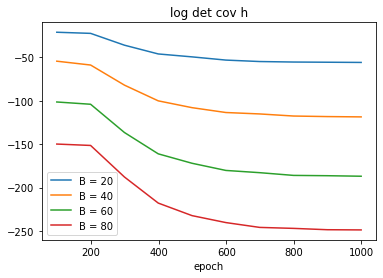

In [45]:
# estimated upper bound of the entropy depends on a batch size
A = [logdet_cov_h_train_20, logdet_cov_h_train_40, logdet_cov_h_train_60, logdet_cov_h_train_80]

for i in range(len(A)):
    result = A[i]
    plt.plot( [99+ 100*i for i in range(10)], list(result.values()), label = 'B = ' + str(20*(i+1)))
    plt.legend()
plt.xlabel('epoch')
plt.title('log det cov h')
plt.show()

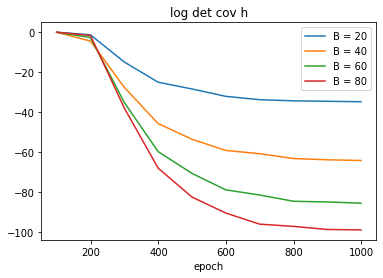

In [46]:
for i in range(len(A)):
    result = A[i]
    my_list = list(result.values())
    my_list_tf = [my_list[i] - my_list[0] for i in range(len(my_list))]
    plt.plot( [99+ 100*i for i in range(10)],my_list_tf, label = 'B = ' + str(20*(i+1)))
    plt.legend()
plt.xlabel('epoch')
plt.title('log det cov h')
plt.show()

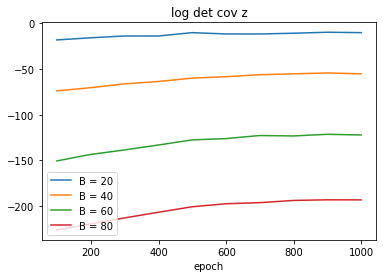

In [47]:
# estimated upper bound of the entropy depends on a batch size
A = [logdet_cov_z_train_20, logdet_cov_z_train_40, logdet_cov_z_train_60, logdet_cov_z_train_80]

for i in range(len(A)):
    result = A[i]
    plt.plot( [99+ 100*i for i in range(10)], list(result.values()), label = 'B = ' + str(20*(i+1)))
    plt.legend()
plt.xlabel('epoch')
plt.title('log det cov z')
plt.show()

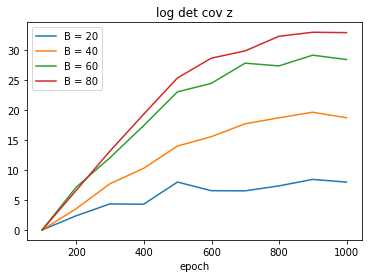

In [48]:
for i in range(len(A)):
    result = A[i]
    my_list = list(result.values())
    my_list_tf = [my_list[i] - my_list[0] for i in range(len(my_list))]
    plt.plot( [99+ 100*i for i in range(10)],my_list_tf, label = 'B = ' + str(20*(i+1)))
    plt.legend()
plt.xlabel('epoch')
plt.title('log det cov z')
plt.show()

In [49]:
#Gendata
X_train, X_test = gen_data(B=20, sample = 100)
checkpointfile = ['resnet18_new.pth99']+ ['resnet18_new.pth' + str(i) + '99' for i in range(1,10)]
logdet_cov_h_giv_x_train20, logdet_cov_z_giv_x_train20 = Batch_x_to_value(X_train, checkpointfile, mode = 'log_det')

100%|██████████| 10/10 [01:12<00:00,  7.25s/it]


In [50]:
#Gendata
X_train, X_test = gen_data(B=40, sample = 100)
checkpointfile = ['resnet18_new.pth99']+ ['resnet18_new.pth' + str(i) + '99' for i in range(1,10)]
logdet_cov_h_giv_x_train40, logdet_cov_z_giv_x_train40 = Batch_x_to_value(X_train, checkpointfile, mode = 'log_det')

100%|██████████| 10/10 [02:20<00:00, 14.03s/it]


In [51]:
#Gendata
X_train, X_test = gen_data(B=60, sample = 100)
checkpointfile = ['resnet18_new.pth99']+ ['resnet18_new.pth' + str(i) + '99' for i in range(1,10)]
logdet_cov_h_giv_x_train60, logdet_cov_z_giv_x_train60 = Batch_x_to_value(X_train, checkpointfile, mode = 'log_det')

100%|██████████| 10/10 [03:31<00:00, 21.11s/it]


In [52]:
#Gendata
X_train, X_test = gen_data(B=80, sample = 100)
checkpointfile = ['resnet18_new.pth99']+ ['resnet18_new.pth' + str(i) + '99' for i in range(1,10)]
logdet_cov_h_giv_x_train80, logdet_cov_z_giv_x_train80 = Batch_x_to_value(X_train, checkpointfile, mode = 'log_det')

100%|██████████| 10/10 [04:40<00:00, 28.06s/it]


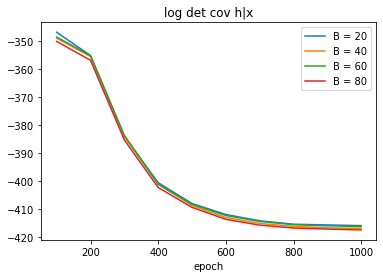

In [53]:
A = [logdet_cov_h_giv_x_train20, logdet_cov_h_giv_x_train40, logdet_cov_h_giv_x_train60, logdet_cov_h_giv_x_train80]

for i in range(len(A)):
    result = A[i]
    plt.plot( [99+ 100*i for i in range(10)], list(result.values()), label = 'B = ' + str(20*(i+1)))
    plt.legend()
plt.xlabel('epoch')
plt.title('log det cov h|x')
plt.show()

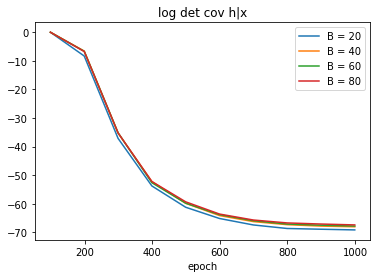

In [54]:
for i in range(len(A)):
    result = A[i]
    my_list = list(result.values())
    my_list_tf = [my_list[i] - my_list[0] for i in range(len(my_list))]
    plt.plot( [99+ 100*i for i in range(10)],my_list_tf, label = 'B = ' + str(20*(i+1)))
    plt.legend()
plt.xlabel('epoch')
plt.title('log det cov h|x')
plt.show()

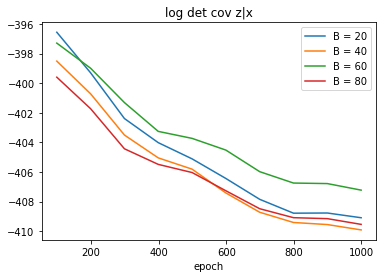

In [55]:
A = [logdet_cov_z_giv_x_train20, logdet_cov_z_giv_x_train40, logdet_cov_z_giv_x_train60, logdet_cov_z_giv_x_train80]

for i in range(len(A)):
    result = A[i]
    plt.plot( [99+ 100*i for i in range(10)], list(result.values()), label = 'B = ' + str(20*(i+1)))
    plt.legend()
plt.xlabel('epoch')
plt.title('log det cov z|x')
plt.show()

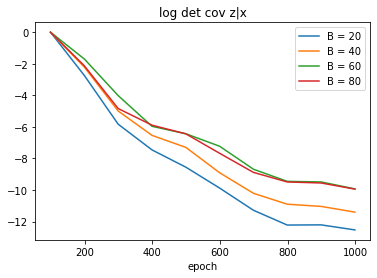

In [56]:
for i in range(len(A)):
    result = A[i]
    my_list = list(result.values())
    my_list_tf = [my_list[i] - my_list[0] for i in range(len(my_list))]
    plt.plot( [99+ 100*i for i in range(10)],my_list_tf, label = 'B = ' + str(20*(i+1)))
    plt.legend()
plt.xlabel('epoch')
plt.title('log det cov z|x')
plt.show()

# expected log det cov(h)

In [165]:
#plot log det cov h against B
B_list = [10*i for i in range(1,20)]
logdet_H = []
logdet_Z = []
trace_H = []
trace_Z = []
for B in tqdm(B_list):
    X_train, X_test = gen_data_1pic(B = B)
    logdet_h, logdet_z = x_to_logdet(X_train, 'resnet18_new.pth399')
    trace_h, trace_z = x_to_trace(X_train, 'resnet18_new.pth399')
    
    logdet_H.append(logdet_h[0])
    logdet_Z.append(logdet_z[0])
    
    trace_H.append(trace_h[0])
    trace_Z.append(trace_z[0])
    

100%|██████████| 19/19 [00:31<00:00,  1.67s/it]


In [166]:
B_list

[10,
 20,
 30,
 40,
 50,
 60,
 70,
 80,
 90,
 100,
 110,
 120,
 130,
 140,
 150,
 160,
 170,
 180,
 190]

In [167]:
logdet_H

[-21.60301629118287,
 -44.842669407996794,
 -72.18860775638467,
 -97.43848452813752,
 -131.96966302257448,
 -158.21469750411603,
 -192.82382619546215,
 -220.1074071261168,
 -254.4350857284645,
 -287.74895720904783,
 -313.5250570341815,
 -345.64856688905815,
 -379.60781469839276,
 -416.3743939502474,
 -444.632920299434,
 -485.1527391739758,
 -521.4790910721022,
 -546.719498024628,
 -589.481414991917]

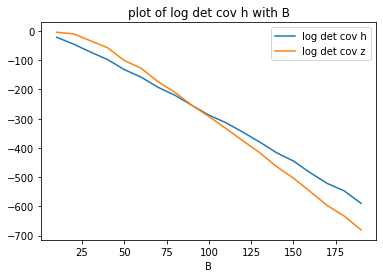

In [168]:
plt.plot(B_list, logdet_H,  label = 'log det cov h')
plt.plot(B_list, logdet_Z,  label = 'log det cov z')
plt.legend()
plt.xlabel('B')
plt.title('plot of log det cov h with B')
plt.show()

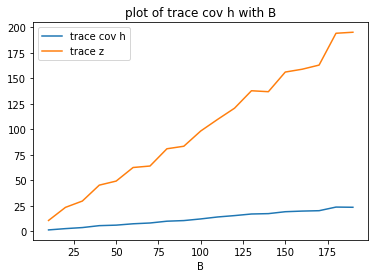

In [169]:
plt.plot(B_list, trace_H,  label = 'trace cov h')
plt.plot(B_list, trace_Z,  label = 'trace z')
plt.legend()
plt.xlabel('B')
plt.title('plot of trace cov h with B')
plt.show()

# check if my code is correct

1) check that this function h_to_cov works properly

In [15]:
multi_norm_dist = torch.distributions.MultivariateNormal(torch.tensor([[0.0, 0.0]]), 
                                                         covariance_matrix = torch.tensor([[1.0,0.0],[0.0,1.0]]))

In [17]:
trace_list = []
for i in range(1,10):
    h_test = []
    for j in range(1000*i):
        h_test.append(multi_norm_dist.sample())
    trace_list.append(cal_trace(h_to_cov(h_test)))

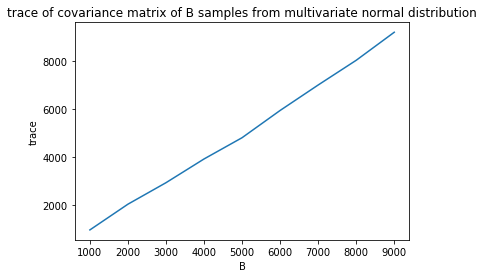

In [21]:
plt.plot([1000*i for i in range(1,10)], trace_list)
plt.xlabel('B')
plt.ylabel('trace')
plt.title('trace of covariance matrix of B samples from multivariate normal distribution')
plt.show()